In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# To simulate a tennis match from scratch, first you must simulate the universe.
# Or, in my case, I start from the simplest unit of a tennis match, the point.
# fsp is the server's observed first service percentage
# fsw is the server's observed first service win percentage
# ssw is the server's observed second service win percentage

def simulate_point(fsp, fsw, ssw):
    return (fsw if fsp > npr.rand() else ssw) > npr.rand()

In [3]:
%%time

simulate_point(0.5, 0.5, 0.5)

CPU times: user 15 µs, sys: 8 µs, total: 23 µs
Wall time: 26 µs


False

In [4]:
%%time

points = [simulate_point(0.5, 0.5, 0.5) for _ in range(1000000)]

CPU times: user 651 ms, sys: 8.61 ms, total: 659 ms
Wall time: 662 ms


In [5]:
sum(points) / len(points)

0.499492

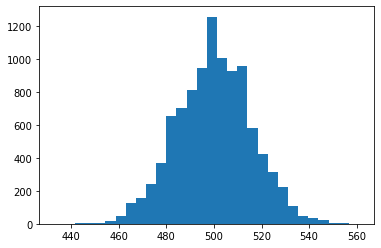

In [6]:
def simulate_points(n):
    return sum(simulate_point(0.5, 0.5, 0.5) for _ in range(n))

_ = plt.hist([simulate_points(1000) for _ in range(10000)], bins=30)

In [7]:
# The next smallest unit in a tennis match is the game. 
# In tennis, the players both start at 0.
# After winning a point, a player goes from 0 --> 15 --> 30 --> 40 --> game won.
# However, if the game is tied at 40-40, then the game is considered at deuce.
# From deuce, whichever player wins 2 straight points wins the game. This state can last indefinitely.
# fsp is the server's observed first serve percentage.
# p is the number of points won and lost by the server.
# From this point on, the functions will keep track of the total points won and lost by the server.
def simulate_deuce(fsp, fsw, ssw, p):
    # A deuce can theoretically last forever
    while True:
        points_won = 0
        for _ in range(2):
            points_won += simulate_point(fsp, fsw, ssw)
        if points_won == 2:
            return (True, p + 2, p)
        elif points_won == 0:
            return (False, p, p + 2)
        else:
            p += 1
            

# To simulate a game, I first simulate the minimum required points.
# I then return any game deciding scores and continue the simulation as required.
# By doing this I never simulate a point that would not be played in a real game.
# fsp is the server's observed first serve percentage.
def simulate_game(fsp, fsw, ssw):
    points_won = 0
    # 4 is the minimum number of points to decide a game.
    for _ in range(4):
        points_won += simulate_point(fsp, fsw, ssw)
    
    # Game won after 40-0
    if points_won == 4:
        return (True, 4, 0)
    # Game lost after 0-40
    elif points_won == 0:
        return (False, 0, 4)
    # 30-30 is identical to Deuce
    elif points_won == 2:
        return simulate_deuce(fsp, fsw, ssw, 2)
    
    # Scenarios remaining: 40-15 and 15-40
    points_won += simulate_point(fsp, fsw, ssw)

    # Game won after 40-15
    if points_won == 4:
        return (True, 4, 1)
    # Game lost after 15-40
    elif points_won == 1:
        return (False, 1, 4)
        
    # Scenarios remaining: 40-30 and 30-40
    points_won += simulate_point(fsp, fsw, ssw)
    # Game won after 40-30
    if points_won == 4:
        return (True, 4, 2)
    # Game lost after 30-40
    elif points_won == 2:
        return (False, 2, 4)
    # Deuce
    else:
        return simulate_deuce(fsp, fsw, ssw, 3)

In [8]:
%%time

# Games with long deuces may take longer.
simulate_game(0.5, 0.5, 0.5)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 18.4 µs


(True, 4, 1)

In [9]:
# Before I can simulate a set properly, I must be able to simulate the tiebreak.
# When a set is tied at 6 games apiece, a tiebreak is played (There are exceptions to this at Grand Slam events)
# A tiebreak is basically a long game, with 7 points as the minimum threshold for victory instead of 4.
# However, the players switch serves on every odd point.

# At 5-5 or 6-6 in a tiebreak, a deuce-like scenario is created.
# Both players serve once each. In real match the order would matter but has no practical effect here.
# *_(p/o) the p and o stand for player and opponent.
def simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw, pl, tbp):
    # A tiebreak can theoretically last forever.
    while True:
        points_won = 0
        
        points_won += simulate_point(fsp_p, fsw_p, ssw_p)
        # When the opponent serves, the result of the simulated point is negated.
        points_won += not simulate_point(fsp_o, fsw_o, ssw_o)
        
        if points_won == 2:
            return (True, pw + 2, pl, 13, f'7-6({tbp})')
        elif points_won == 0:
            return (False, pw, pl + 2, 13, f'6-7({tbp})') 
        else:
            pw += 1
            pl += 1
            tbp += 1
            

# I have continued the "unrolled loop" approach, as despite being more verbose it performs well.
# *_(p/o) the p and o stand for player and opponent. The player serves first.
def simulate_tiebreak(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw, pl):
    points_won = 0
    
    # 7 is the minimum number of points to decide a tiebreak.
    # In the first 7 points, the player serves 3 times to the opponents 4
    for _ in range(3):
        points_won += simulate_point(fsp_p, fsw_p, ssw_p)
    # When the opponent serves, the result of the simulated point is negated.
    for _ in range(4):
        points_won += not simulate_point(fsp_o, fsw_o, ssw_o)
        
    # Tiebreak won after 7-0
    if points_won == 7:
        return (True, pw + 7, pl, 13, '7-6(0)')
    # Tiebreak lost after 0-7
    elif points_won == 0:
        return (False, pw, pl + 7, 13, '6-7(0)')
    
    # Scenarios remaining: 6-1, 5-2, 4-3, 3-4, 2-5, 1-6
    # The player serves next.
    points_won += simulate_point(fsp_p, fsw_p, ssw_p)
    
    # Tiebreak won after 7-1
    if points_won == 7:
        return (True, pw + 7, pl + 1, 13, '7-6(1)')
    # Tiebreak lost after 1-7
    elif points_won == 1:
        return (False, pw + 1, pl + 7, 13, '6-7(1)')
    
    # Scenarios remaining: 6-2, 5-3, 4-4, 3-5, 2-6
    # The player serves next.
    points_won += simulate_point(fsp_p, fsw_p, ssw_p)
    
    # Tiebreak won after 7-2
    if points_won == 7:
        return (True, pw + 7, pl + 2, 13, '7-6(2)')
    # Tiebreak lost after 2-7
    elif points_won == 2:
        return (False, pw + 2, pl + 7, 13, '6-7(2)')
    
    # Scenarios remaining: 6-3, 5-4, 4-5, 3-6
    # The opponent serves next
    points_won += not simulate_point(fsp_o, fsw_o, ssw_o)
    
    # Tiebreak won after 7-3
    if points_won == 7:
        return (True, pw + 7, pl + 3, 13, '7-6(3)')
    # Tiebreak lost after 3-7
    elif points_won == 3:
        return (False, pw + 3, pl + 7, 13, '6-7(3)')
    # At 5-5, the tiebreak is in a state similar to deuce.
    elif points_won == 5:
        return simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw + 5, pl + 5, 5)
    
    # Scenarios remaining: 6-4, 4-6
    # The opponent serves next
    points_won += not simulate_point(fsp_o, fsw_o, ssw_o)
    
    # Tiebreak won after 7-4
    if points_won == 7:
        return (True, pw + 7, pl + 4, 13, '7-6(4)')
    # Tiebreak lost after 4-7
    elif points_won == 4:
        return (False, pw + 4, pl + 7, 13, '6-7(4)')
    # Scenarios remaining: 6-5, 5-6
    # The player serves next
    points_won += simulate_point(fsp_p, fsw_p, ssw_p)
    
    # Tiebreak won after 7-5
    if points_won == 7:
        return (True, pw + 7, pl + 5, 13, '7-6(5)')
    # Tiebreak lost after 5-7
    elif points_won == 5:
        return (False, pw + 5, pl + 7, 13, '6-7(5)')
    # Scenarios remaining: 6-6, which is a deuce situation
    else:
        return simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw + 6, pw + 6, 6)

In [10]:
%%time

simulate_tiebreak(.5, .5, .5, .5, .5, .5, 0, 0)

CPU times: user 36 µs, sys: 3 µs, total: 39 µs
Wall time: 49.1 µs


(True, 8, 6, 13, '7-6(6)')

In [11]:
def simulate_games_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o):
    # A games deuce can theoretically last forever.
    games_played = 10
    points_won = 0
    points_lost = 0
    g = 5
    while True:
        games_won = 0
        
        (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
        games_won += game_result
        points_won += pw
        points_lost += pl
    
        (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
        games_won += not game_result
        points_won += pl
        points_lost += pw
        
        games_played += 2
        
        if games_won == 2:
            return (True, points_won, points_lost, games_played, f'{g + 2}-{g}')
        elif games_won == 0:
            return (False, points_won, points_lost, games_played, f'{g}-{g + 2}')
        else:
            g += 1

In [12]:
# The biggest sub-unit of a tennis match is the set.
# Each set acts like a tiebreak, with points replaced by games.
# A player must win 6 games to win a set, and with two games or more than the opponent.
# In the event of a tie at 6 games apiece, a tiebreak is played.
# Scorelines of 7-5 are also possible, and can only occur from 5 games apiece.
# The players switch serves each game. 
# In the tiebreak, the player who returned in the previous game serves first.
def simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, tb=True):
    games_won = 0
    points_won = 0
    points_lost = 0
    # 6 is the minimum number of games to decide a set.
    # In the first 6 games, each player serves 3 times.
    for i in range(3):
        (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
        games_won += game_result
        points_won += pw
        points_lost += pl
        
        (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
        games_won += not game_result
        points_won += pl
        points_lost += pw
        
    # Set won after 6-0
    if games_won == 6:
        return (True, points_won, points_lost, 6, '6-0')
    # Set lost after 0-6
    elif games_won == 0:
        return (False, points_won, points_lost, 6, '0-6')
    
    # Scenarios remaining: 5-1, 4-2, 3-3, 2-4, 1-5
    # The player serves next.
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    # Set won after 6-1
    if games_won == 6:
        return (True, points_won, points_lost, 7, '6-1')
    # Set lost after 1-6
    elif games_won == 1:
        return (False, points_won, points_lost, 7, '1-6')
    
    # Scenarios remaining: 5-2, 4-3, 3-4, 2-5
    # The opponent serves next.
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 6-2
    if games_won == 6:
        return (True, points_won, points_lost, 8, '6-2')
    # Set lost after 2-6
    elif games_won == 2:
        return (False, points_won, points_lost, 8, '2-6')
    
    # Scenarios remaining: 5-3, 4-4, 3-5
    # The player serves next.
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    # Set won after 6-3
    if games_won == 6:
        return (True, points_won, points_lost, 9, '6-3')
    # Set lost after 3-6
    elif games_won == 3:
        return (False, points_won, points_lost, 9, '3-6')
    
    # Scenarios remaining: 5-4, 4-5
    # The opponent serves next.
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 6-4
    if games_won == 6:
        return (True, points_won, points_lost, 10, '6-4')
    # Set lost after 4-6
    elif games_won == 4:
        return (False, points_won, points_lost, 10, '4-6')
    
    
    
    # Scenarios remaining: 5-5
    # If this is the 5th set, and there is not finel set tiebreaker,
    # then the match continues until one player has a 2 game advantage.
    if not tb:
        (result, pw, pl, gp, score) = simulate_games_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        return (result, points_won + pw, points_lost + pl, gp, score)
    
    
    # Neither player can win on the next game, so 2 games are simulated
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 7-5
    if games_won == 7:
        return (True, points_won, points_lost, 12, '7-5')
    # Set lost after 5-7
    elif games_won == 5:
        return (False, points_won, points_lost, 12, '5-7')
    # Tied at 6-6, so go to a tiebreak
    else:
        return simulate_tiebreak(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, points_won, points_lost)

In [13]:
%%time

simulate_set(.5, .5, .5, .5, .5, .5)

CPU times: user 117 µs, sys: 10 µs, total: 127 µs
Wall time: 141 µs


(True, 40, 30, 9, '6-3')

In [14]:
def generate_sets(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, n=1):
    results = np.empty(n, dtype=object)
    
    for i in range(n):
        results[i] = list(simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o))
    
    return pd.DataFrame.from_records(results,
                                     columns=['result', 'points_won', 'points_lost', 'games_played', 'score'])

In [15]:
%%time

data_set = generate_sets(.5, .5, .5, .5, .5, .5, 1000000)

CPU times: user 51.8 s, sys: 230 ms, total: 52.1 s
Wall time: 52.3 s


In [16]:
data_set.result.value_counts()

True     500162
False    499838
Name: result, dtype: int64

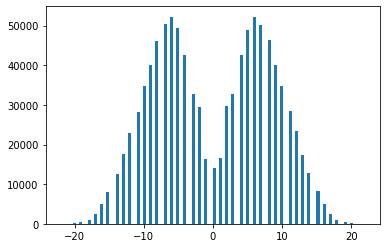

In [17]:
_ = plt.hist(data_set.points_won - data_set.points_lost, bins=100)

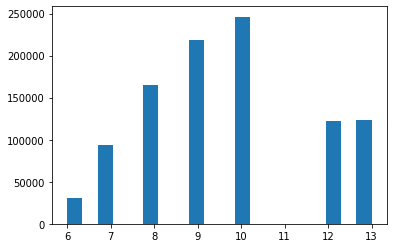

In [18]:
_ = plt.hist(data_set.games_played, bins=20)

In [19]:
data_set[data_set.games_played > 9].result.value_counts()

False    245981
True     245655
Name: result, dtype: int64

In [20]:
data_set.score.astype('category').value_counts().nlargest(14)

4-6       123391
6-4       122860
3-6       109287
6-3       109129
6-2        82457
2-6        82091
7-5        61445
5-7        61066
6-1        47283
1-6        46972
6-0        15638
0-6        15507
6-7(5)     14007
7-6(5)     13811
Name: score, dtype: int64

In [21]:
def bootstrap_sample(params, n=100):
    wins = generate_sets(*params, n).result.sum()
    losses = n - wins
    return wins - losses

In [22]:
%%time

bs_samples_50 = [bootstrap_sample((.5, .5, .5, .5, .5, .5)) for _ in range(10000)]

CPU times: user 1min 3s, sys: 343 ms, total: 1min 3s
Wall time: 1min 4s


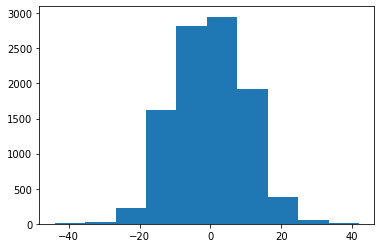

In [23]:
_ = plt.hist(bs_samples_50, bins=10)

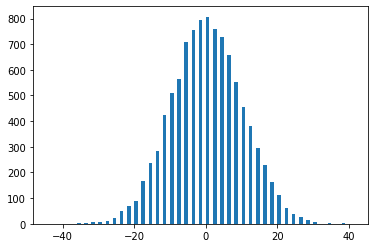

In [24]:
_ = plt.hist(bs_samples_50, bins=range(min(bs_samples_50), max(bs_samples_50)))

In [25]:
bs_samples_75 = [bootstrap_sample((.5, .75, .75, .5, .75, .75)) for _ in range(10000)]

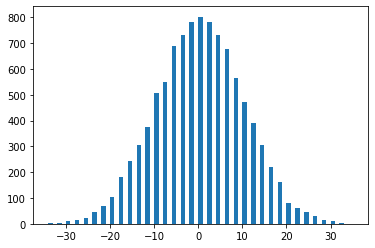

In [26]:
_ = plt.hist(bs_samples_75, bins=range(min(bs_samples_75), max(bs_samples_75)))

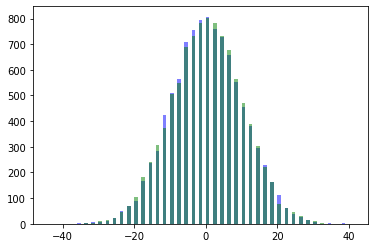

In [27]:
_ = plt.hist(bs_samples_50, bins=range(min(bs_samples_50), max(bs_samples_50)), color='b', alpha=0.5)
_ = plt.hist(bs_samples_75, bins=range(min(bs_samples_75), max(bs_samples_75)), color='g', alpha=0.5)

In [28]:
len(list(filter(lambda x: x > 0, bs_samples_50))) / len(bs_samples_50)

0.4489

In [29]:
len(list(filter(lambda x: x > 0, bs_samples_75))) / len(bs_samples_50)

0.4561

In [30]:
def reverse_score(score):
    get_tb = score.split('(')
    tb = f'({get_tb[1].split(")")[0]})' if len(get_tb) == 2 else ''
    
    get_sets = score.split('-')
        
    return f'{get_sets[1].split("(")[0]}-{get_sets[0]}{tb}'

In [31]:
# The end is finally in sight. 
# Depending on the tournament, matches may be best of 3 or 5 sets. 
# For now, I will focus only on simulating 5 set matches.
def simulate_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o):
    sets_won = 0
    points_won = 0
    points_lost = 0
    games_played = 0
    final_score = []
    
    # Before each match, a coin is tossed to determine who serves first.
    coin_toss = npr.rand() > 0.5
    # First set
    if coin_toss:
        (set_result, pw, pl, games, score) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
        final_score.append(score)
    else:
        (set_result, pw, pl, games, score) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
        final_score.append(reverse_score(score))
                
    # Second set
    # The server is instead determined by the total games played in the previous sets.
    # If total games is even, then the serve order stays the same.
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games, score) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
        final_score.append(score)
    else:
        (set_result, pw, pl, games, score) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
        final_score.append(reverse_score(score))
        
    # Third set
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games, score) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
        final_score.append(score)
    else:
        (set_result, pw, pl, games, score) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
        final_score.append(reverse_score(score))
        
    # If the score is 3-0 or 0-3, return with the results.
    if sets_won == 3:
        return [True, coin_toss, points_won, points_lost, games_played, 3, " ".join(final_score)]
    elif sets_won == 0:
        return [False, coin_toss, points_won, points_lost, games_played, 3, " ".join(final_score)]
       
    # Otherwise, simulate the next set              
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games, score) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
        final_score.append(score)
    else:
        (set_result, pw, pl, games, score) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
        final_score.append(reverse_score(score))
                
    # If the score is 3-1 or 1-3, return with the results.
    if sets_won == 3:
        return np.array([True, coin_toss, points_won, points_lost, games_played, 4, " ".join(final_score)])
    elif sets_won == 1:
        return np.array([False, coin_toss, points_won, points_lost, games_played, 4, " ".join(final_score)])
        
    # Otherwise, simulate the deciding set              
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games, score) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, tb=False)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
        final_score.append(score)
    else:
        (set_result, pw, pl, games, score) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p, tb=False)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
        final_score.append(reverse_score(score))
                        
    # Whether the score is 3-2 or 2-3, return with the results.
    if sets_won == 3:
        return np.array([True, coin_toss, points_won, points_lost, games_played, 5, " ".join(final_score)])
    else:
        return np.array([False, coin_toss, points_won, points_lost, games_played, 5, " ".join(final_score)])

In [32]:
%%time

simulate_match(.735, .809, .631, .671, .866, .627)

CPU times: user 271 µs, sys: 1 µs, total: 272 µs
Wall time: 279 µs


[False, True, 109, 123, 38, 3, '6-7(4) 5-7 6-7(5)']

Phew. Now that all of that is out of the way, I can write a function to create a variable number of bootstrap samples to explore.

In [33]:
def bootstrap_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, n=1):
    results = np.empty(n, dtype=object)
    
    for i in range(n):
        results[i] = simulate_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
    
    return results

On my machine, I can simulate the results of 10,000 matches in just over 2 seconds. Not bad.

In [34]:
%%time

pd.DataFrame.from_records(bootstrap_match(.735, .809, .631, .671, .866, .627, 100000),
                          columns=['result', 'first_serve', 'points_won', 'points_lost', 'games', 'sets', 'score'])


CPU times: user 25.5 s, sys: 118 ms, total: 25.6 s
Wall time: 25.7 s


,1,hi,3,4,5,6,7
0,False,True,539,553,209,5,7-6(5) 6-7(5) 4-6 7-6(5) 79-81
1,True,True,109,101,35,3,6-3 7-6(8) 7-6(5)
2,True,True,124,130,45,4,7-6(6) 3-6 6-4 7-6(5)
3,False,True,159,164,58,5,7-6(3) 6-7(2) 6-7(3) 6-3 4-6
4,False,True,184,184,67,5,6-3 6-7(2) 6-7(1) 6-4 10-12
...,...,...,...,...,...,...,...
99995,True,True,123,122,39,3,7-6(5) 7-6(6) 7-6(18)
99996,True,True,124,124,45,4,4-6 6-3 7-6(5) 7-6(5)
99997,False,False,109,110,36,3,4-6 6-7(9) 6-7(5)
99998,False,False,122,134,49,5,5-7 6-4 3-6 6-3 3-6


It's finally time to look at the simulated matches between Nadal and Medvedev. I generated 10,000 bootstrapped samples for analysis. All results with a value of True represent a simulated match in which Nadal won.

55% of the simulated matches resulted in a victory for Nadal. This result makes sense, as the statistics for both players are quite similar.

In [35]:
bootstraps.result.sum() / bootstraps.result.size

NameError: name 'bootstraps' is not defined

To represent the simulations graphically, I plotted two separate histograms, one for the wins and one for the losses. The x-axis represents the point differential of the match, or the points won by Nadal subtracted by the points won by Medvedev. I also marked the 95% confidence intervals for both the wins and loss point differentials, and the actual point defferential for the match.

In [ ]:
plt.rcParams['figure.figsize'] = [9, 5]

bootstraps['points_diff'] = bootstraps.points_won - bootstraps.points_lost
bootstraps['points_won_percentage'] = bootstraps.points_won / (bootstraps.points_won + bootstraps.points_lost)
wins = bootstraps[bootstraps.result == True]
losses = bootstraps[bootstraps.result == False]

confidence_wins = np.percentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(bootstraps.points_diff) + 1) - abs(bootstraps.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)


_ = plt.axvline(478 - 502, linestyle='-', color='green', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='--', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='--', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='--', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='--', color='darkred')

_ = plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]

confidence_wins = np.percentile(wins.points_won_percentage, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_won_percentage, [2.5, 97.5])

_ = plt.hist(wins.points_won_percentage, bins=30, color='blue', alpha=0.5)
_ = plt.hist(losses.points_won_percentage, bins=30, color='red', alpha=0.5)

_ = plt.axvline(478/(478 + 502) , linestyle='-', color='green', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='--', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='--', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='--', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='--', color='darkred')

plt.legend()
plt.xlabel('Points Won Pct.')
plt.ylabel('Frequency')
_ = plt.title('Bootstrap Match Results Nadal vs Medvedev')